# Autoencoders

Итоговый проект первого семестра DLS2020-spring. Тренировка автоэнкодеров.


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
import os
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Маунтим гугл-драйв с заранее скачанными и предобработанными определенным образом файлами датасета.

from google.colab import drive
drive.mount('/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
def plot_gallery(images, h, w, n_chan=3, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, n_chan)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass
  

In [5]:
def to_print(images):
  images_print = images.data.cpu()
  return images_print.permute(0, 2, 3,1)



In [6]:
# Подгружаем трейн и тест датасеты и набор атрибутов
X_train = torch.load('/gdrive/My Drive/DLS2020/X_train.pt')
X_val = torch.load('/gdrive/My Drive/DLS2020/X_val.pt')

Y_train = torch.load('/gdrive/My Drive/DLS2020/Y_train.pt')
Y_val = torch.load('/gdrive/My Drive/DLS2020/Y_val.pt')


In [7]:
# определим размеры избражения
IMAGE_H = X_train.shape[1]
IMAGE_W = X_train.shape[2]

# у нас цветные изображения
N_CHANNELS = X_train.shape[3]

# Посмотрим на список атрибутов
print(Y_train.columns)

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

## Посмотрим на наши лица

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

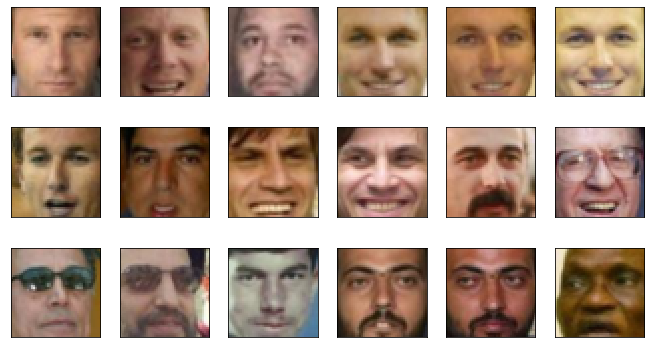

In [81]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

In [8]:
# Разобъем данные по выборкам: общую, улыбающуюся, хмурящуюсь и с бородкой ("Goatee")
def slice_data(X_train, Y_train, val=False, feature='Smiling', condition='>', filter=0.99):
  if condition == '>':
    smiling = Y_train.loc[Y_train[feature] > filter].index.tolist()  
  else:
    smiling = Y_train.loc[Y_train[feature] < filter].index.tolist()  
  
  if val:
    smiling = [(x - 10000) for x in smiling]

  X_smiling_train = X_train[smiling,:]
  Y_smiling_train = Y_train.iloc[smiling,:]
  
  return X_smiling_train, Y_smiling_train
  


X_smiling_train, Y_smiling_train = slice_data(X_train=X_train, Y_train=Y_train, val=False, feature='Smiling', condition='>', filter=0.99)
X_grumpy_train, Y_grumpy_train = slice_data(X_train=X_train, Y_train=Y_train, val=False, feature='Frowning', condition='>', filter=0.99)

X_smiling_val, Y_smiling_val = slice_data(X_train=X_train, Y_train=Y_train, val=True, feature='Smiling', condition='>', filter=0.99)
X_grumpy_val, Y_grumpy_val = slice_data(X_train=X_train, Y_train=Y_train, val=True, feature='Frowning', condition='>', filter=0.99)

X_goatee_train, Y_goatee_train = slice_data(X_train=X_train, Y_train=Y_train, val=False, feature="Goatee", condition='>', filter=0.9)
X_no_goatee_train, Y_no_goatee_train = slice_data(X_train=X_train, Y_train=Y_train, val=False, feature="Goatee", condition='<', filter=0.9)

X_goatee_val, Y_goatee_val = slice_data(X_train=X_train, Y_train=Y_train, val=True, feature="Goatee", condition='>', filter=0.99)
X_no_goatee_val, Y_no_goatee_val = slice_data(X_train=X_train, Y_train=Y_train, val=True, feature="Goatee", condition='<', filter=0.99)


Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [9]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 64

def prepare_loader(X, Y, batch_size, conv=False):
  if conv:
    X = torch.from_numpy(np.rollaxis(X.astype(np.float32)/255, 3,1))
  else:
    X = torch.from_numpy(X.astype(np.float32)/255) 
  
  Y = torch.Tensor(Y.values.astype(float))
  
  data_tr = TensorDataset(X, Y)
  data_tr = DataLoader(data_tr,  batch_size=batch_size, shuffle=True)

  return data_tr


### prepare data for smile substitution (I will use convolution based autoencoder, hence conv=True flag, as it moves chanels dimention before width and hight)
smiling_tr = prepare_loader(X_smiling_train, Y_smiling_train, batch_size, conv=True)
smiling_val = prepare_loader(X_smiling_val, Y_smiling_val, batch_size, conv=True)

grumpy_tr = prepare_loader(X_grumpy_train, Y_grumpy_train, batch_size, conv=True)
grumpy_val = prepare_loader(X_grumpy_val, Y_grumpy_val, batch_size, conv=True)

goatee_tr = prepare_loader(X_goatee_train, Y_goatee_train, batch_size, conv=True)
goatee_val = prepare_loader(X_goatee_val, Y_goatee_val, batch_size, conv=True)

no_goatee_tr = prepare_loader(X_no_goatee_train, Y_no_goatee_train, batch_size, conv=True)
no_goatee_val = prepare_loader(X_no_goatee_val, Y_no_goatee_val, batch_size, conv=True)


### prepare total data 
data_tr = prepare_loader(X_train, Y_train, batch_size)
data_val = prepare_loader(X_val, Y_val, batch_size)

data_tr_conv = prepare_loader(X_train, Y_train, batch_size, conv=True)
data_val_conv = prepare_loader(X_val, Y_val, batch_size, conv=True)


In [10]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

## ЛИНЕЙНЫЙ АВТОЭНКОДЕР



In [14]:
## Линейный автоэнкодер
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        # архитектура encoder
        super().__init__()
        self.encoder_hidden_layer = nn.Sequential(
          nn.Linear(in_features=kwargs["input_shape"], out_features=128),
          nn.ReLU(),
          nn.BatchNorm1d(128)
        )
        self.encoder_output_layer =  nn.Sequential(
          nn.Linear(in_features=128, out_features=128),
          nn.Sigmoid()
        )
        # архитектура decoder
        self.decoder_hidden_layer = nn.Sequential(
          nn.Linear(in_features=128, out_features=128),
          nn.ReLU(),
        )
        self.decoder_output_layer = nn.Sequential(
          nn.Linear(in_features=128, out_features=kwargs["input_shape"]),
          nn.Sigmoid()
        )

    def forward(self, x):
        #<реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>
        activation = self.encoder_hidden_layer(x)
        latent_code = self.encoder_output_layer(activation)
        activation = torch.relu(latent_code)
        activation = self.decoder_hidden_layer(activation)
        reconstruction = self.decoder_output_layer(activation)
        
        return reconstruction, latent_code

In [13]:
def plot_gallery2(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    #print(images)
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        #print(images[i].shape)
        try:
            plt.imshow(images[i].reshape(45,45,3), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
  
    for inputs, _ in train_loader:
        inputs = inputs.reshape(-1, IMAGE_H * IMAGE_W * N_CHANNELS).to(device)
        optimizer.zero_grad()

        reconstruction, latent_codes = model(inputs)
        loss = criterion(reconstruction, inputs)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    
    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, _ in val_loader:
        inputs_ = inputs.reshape(-1, IMAGE_H * IMAGE_W * N_CHANNELS).to(device)

        with torch.set_grad_enabled(False):
            reconstruction, latent_codes = model(inputs_)
            loss = criterion(reconstruction, inputs_)
            recon = (reconstruction.reshape(-1, 45, 45, 3)*255).int()
            inputs = (inputs.reshape(-1, 45, 45, 3)*255).int()

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    for i in range(inputs.shape[0]):
      plot_gallery2([inputs[i].detach().to('cpu'), recon[i].detach().to('cpu')], IMAGE_H, IMAGE_H, n_row=1, n_col=2)
   
    val_loss = running_loss / processed_size
    
    return val_loss

def train(train_loader, val_loader, model, epochs, optimizer="AdamW"):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} "

    print('\nOptimizer = ', optimizer)
    if optimizer == "AdamW":
      opt = torch.optim.AdamW(model.parameters())
    elif optimizer == "SGD":
      opt = torch.optim.SGD(list(model.parameters()), lr=0.001, momentum=0.9)
      
    criterion = nn.MSELoss(reduction='mean')
        
    for epoch in range(epochs):
      train_loss = fit_epoch(model, train_loader, criterion, opt)
      print("loss", train_loss)
            
      val_loss = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, val_loss))
                   
    return history

Вот что получилось. Автоэнкодер вполне сносно восстанавливает картинки, немножко заблюрено, но в целом угадываемо. А главное - просто летает! В качестве изображения выводятся последние три картинки в каждом цикле обучения.


Optimizer =  AdamW
loss 0.017287395464256405
loss 0.01113636545278132
loss 0.00983777593728155
loss 0.00928066320810467
loss 0.008822667936794459
loss 0.008480820714496077
loss 0.007916289510205388


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


loss 0.007436146573163569
loss 0.007151715508196503
loss 0.00693845171155408
loss 0.006770242355763912
loss 0.006581194476224482
loss 0.006376034030225128
loss 0.006220711682457477
loss 0.006123033309355378
loss 0.006009305012878031
loss 0.005849613798316568
loss 0.005749282048083842
loss 0.0056585465744137765
loss 0.005548438685480505


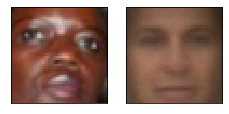

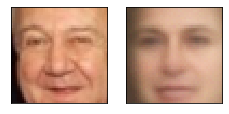

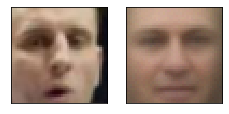

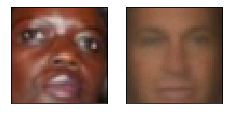

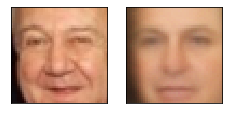

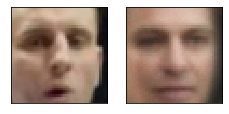

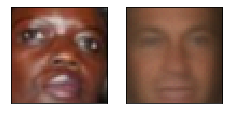

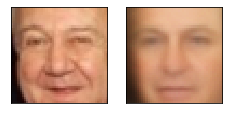

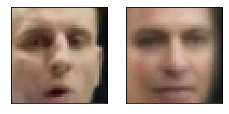

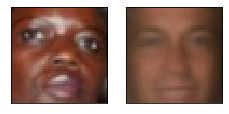

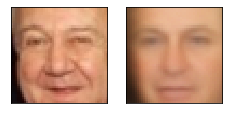

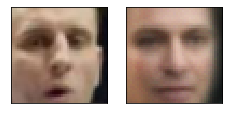

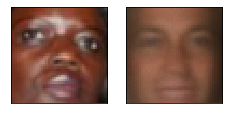

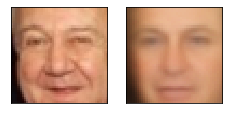

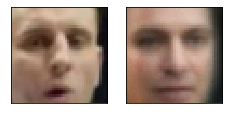

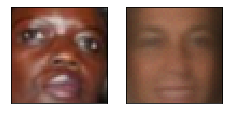

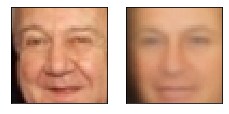

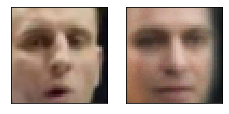

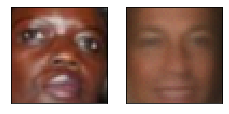

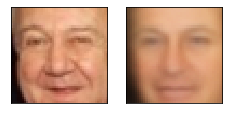

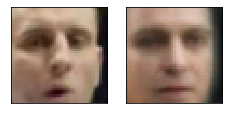

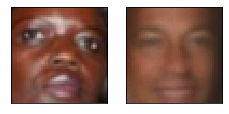

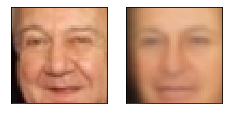

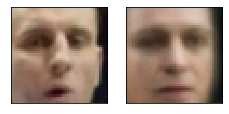

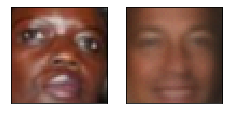

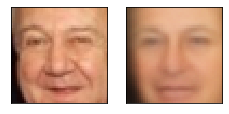

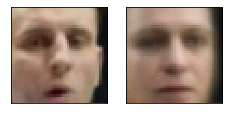

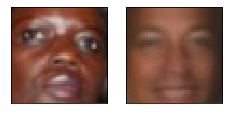

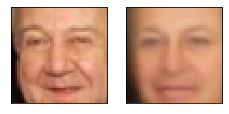

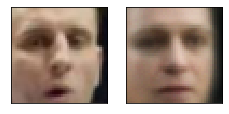

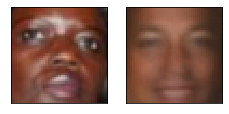

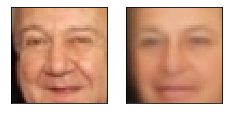

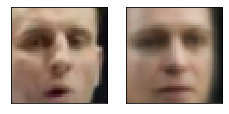

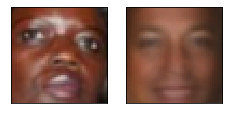

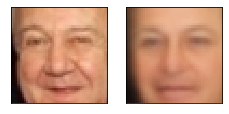

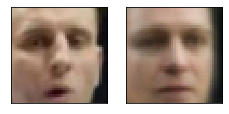

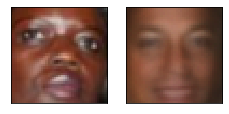

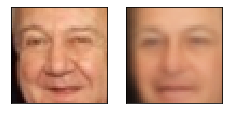

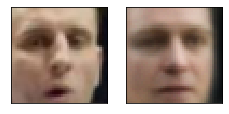

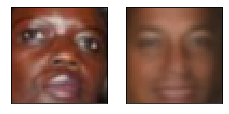

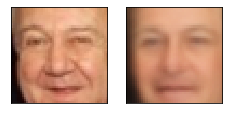

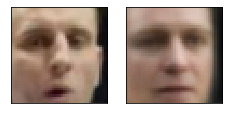

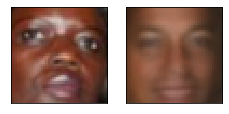

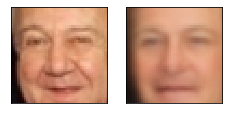

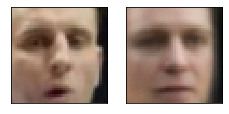

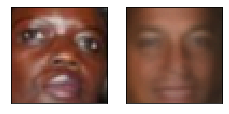

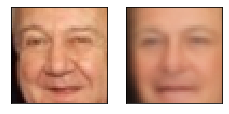

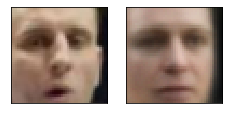

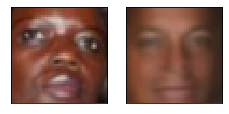

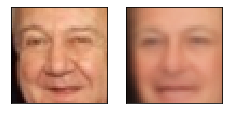

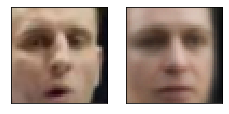

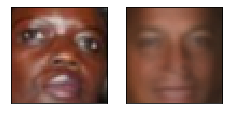

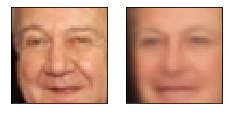

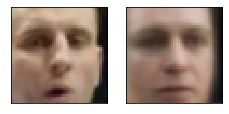

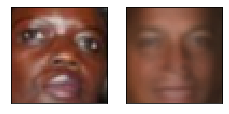

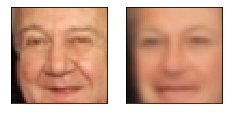

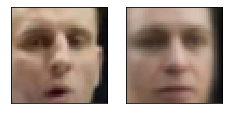

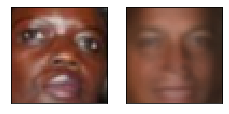

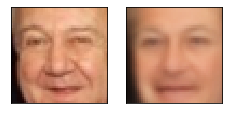

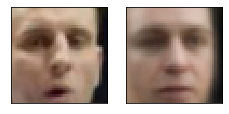

In [17]:
autoencoder = Autoencoder(input_shape = IMAGE_H * IMAGE_W * 3).to(device) 
epochs = 20
history = train(data_tr, data_val, autoencoder, epochs)

In [ ]:
loss, val_loss = zip(*history)

Построим графики лоссов для обучающей и валидационной выборки. Как видим, модель не успевает переобучаться на 20 эпохах.

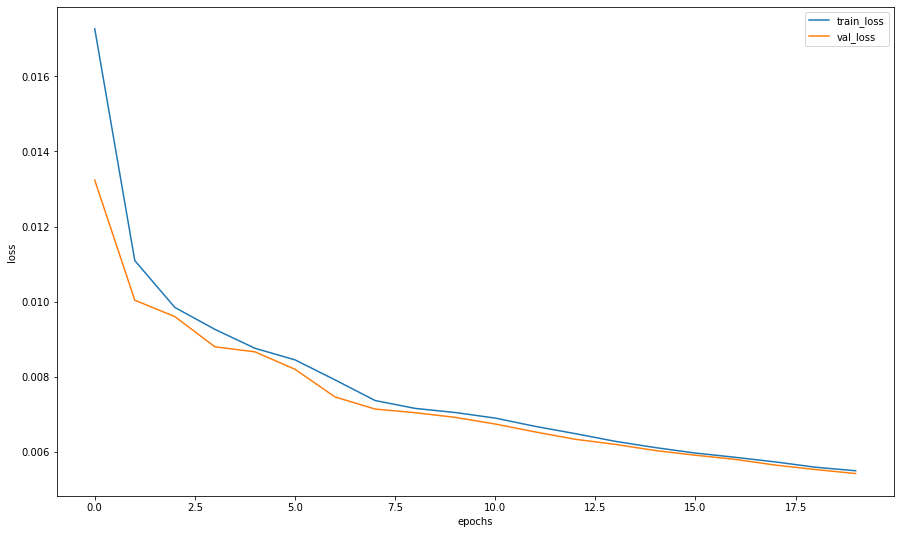

In [51]:

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## АВТОЭНКОДЕР СО СВЕРТКОЙ

### Вариант 1. Совсем простой.

In [64]:
# автоэнкодер на основе свертки
class Autoencoder2(nn.Module):
    
    def __init__(self, code_size):
        super().__init__()
        self.code_size = code_size
        
        # Encoder specification
        self.enc_cnn_1 = nn.Conv2d(N_CHANNELS, 10, kernel_size=5)
        self.enc_cnn_2 = nn.Conv2d(10, 20, kernel_size=5)
        self.enc_linear_1 = nn.Linear(1280, 100)
        self.enc_linear_2 = nn.Linear(100, self.code_size)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(self.code_size, 200)
        self.dec_linear_2 = nn.Linear(200, IMAGE_H * IMAGE_W * N_CHANNELS)
        
    def forward(self, images):
        code = self.encode(images)
        out = self.decode(code)
        return out, code
    
    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = F.selu(F.max_pool2d(code, 2))
        
        code = self.enc_cnn_2(code)
        code = F.selu(F.max_pool2d(code, 2))
        
        code = code.view([images.size(0), -1])
        code = F.selu(self.enc_linear_1(code))
        code = self.enc_linear_2(code)
        return code
    
    def decode(self, code):
        out = F.selu(self.dec_linear_1(code))
        out = torch.sigmoid(self.dec_linear_2(out))
        out = out.reshape([code.size(0), N_CHANNELS, IMAGE_W, IMAGE_H])
        return out

In [65]:
def train2(data_loader, model, epochs, optimizer, criterion):
  codes = torch.empty(1, 100)
  cnt = 0
  for epoch in range(epochs):
      for images, _ in data_loader: 
          
          optimizer.zero_grad()
          out, code = model(images.to(device))
          loss = criterion(out, images.to(device))
          loss.backward()
          optimizer.step()
    
      print("Epoch %d Loss = %.3f" % (epoch, loss.data))
  return out, images, code

In [67]:
### ОБУЧАЕМ НА ДАТАСЕТЕ УЛЫБОК, ТК МНЕ НРАВЯТСЯ УЛЫБАЮЩИЕСЯ ЛЮДИ

autoencoder2 = Autoencoder2(code_size=dim_code).to(device)

optimizer = torch.optim.AdamW(autoencoder2.parameters())
criterion = nn.MSELoss(reduction='mean')
epochs = 10
out, images, codes = train2(data_loader=smiling_tr, model=autoencoder2, epochs=epochs, optimizer=optimizer, criterion=criterion)


Epoch 0 Loss = 0.010
Epoch 1 Loss = 0.007
Epoch 2 Loss = 0.008
Epoch 3 Loss = 0.006
Epoch 4 Loss = 0.004
Epoch 5 Loss = 0.005
Epoch 6 Loss = 0.005
Epoch 7 Loss = 0.005
Epoch 8 Loss = 0.008
Epoch 9 Loss = 0.004


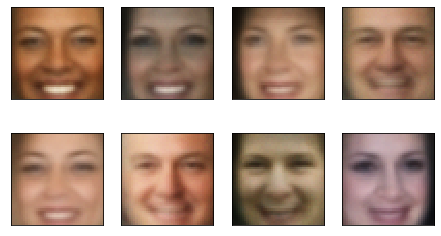

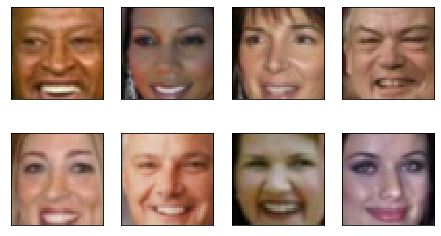

In [69]:
out_print = out.data.cpu()
out_print = out_print.permute(0, 2, 3,1)

images_print = images.data
images_print = images_print.permute(0, 2, 3,1)


plot_gallery(out_print, 45,45,3,2,4)
plot_gallery(images_print, 45,45,3,2,4)

### Вариант 2. Самый сложный из ванильных. 

In [11]:
# автоэнкодер на основе свертки. ВАРИАНТ С ОБРАТНОЙ СВЕРТКОЙ В ДЕКОДЕРЕ. БОЛЬШОЙ, СЛОЖНЫЙ И ПЛОХО РАБОТАЕТ
class Encoder(nn.Module):
    def __init__(self,code_size):
        super(Encoder, self).__init__()
        # encoder (downsampling)
        self.code_size = code_size
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(N_CHANNELS, 45, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(45),
            nn.ReLU(),
            nn.Conv2d(45, 45, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(45),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 45 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(45, 90, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(90),
            nn.ReLU(),
            nn.Conv2d(90, 90, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(90),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(90, 180, kernel_size=(3, 3),  padding=(1, 1), bias=False),
            nn.BatchNorm2d(180),
            nn.ReLU(),
            nn.Conv2d(180, 180, kernel_size=(3, 3),  padding=(1, 1), bias=False),
            nn.BatchNorm2d(180),
            nn.ReLU()
            ) 
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(180, 320, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(320),
            nn.ReLU(),
            nn.Conv2d(320, 320, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(320),
            nn.ReLU()
            )
        self.pool3 =  nn.MaxPool2d(kernel_size=5, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_fc = nn.Sequential(
            nn.Linear(320*1*1, self.code_size),
            nn.ReLU()
            )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))
        
        # bottleneck
        e3 = e3.reshape(-1, 320*1*1)
        b = self.bottleneck_fc(e3)
        return b

class Decoder(nn.Module):
    def __init__(self,code_size):
        super(Decoder, self).__init__()
        
        self.code_size = code_size

        # bottleneck
        self.bottleneck_fc = nn.Sequential(
            nn.Linear(self.code_size, 320*1*1),
            nn.ReLU()
            )
        
        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=5) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(320),
            nn.ReLU(),
            nn.Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(320),
            nn.ReLU()
            )
        self.upsample1 =  nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(320),
            nn.ReLU(),
            nn.Conv2d(320, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(180),
            nn.ReLU()
            )
        self.upsample2 = nn.Upsample(scale_factor=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(180, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(180),
            nn.ReLU(),
            nn.Conv2d(180, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(90),
            nn.ReLU()
            )
        self.upsample3 =  nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(90, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(45),
            nn.ReLU(),
            nn.Conv2d(45, N_CHANNELS, kernel_size=(2, 2), stride=(1, 1), padding=(3, 3), bias=False),
            nn.BatchNorm2d(N_CHANNELS)
            )
        

    def forward(self, b):
        # decoder
        b = self.bottleneck_fc(b)
        b = b.reshape(-1, 320, 1, 1)
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = torch.sigmoid(self.dec_conv3(self.upsample3(d2)))
        
        return d3

### Вариант 3. Средней сложности. ЛУЧШИЙ!

In [8]:
# автоэнкодер на основе свертки. ПРОСТОЙ, НО РАБОТАЕТ ЛУЧШЕ
class Encoder(nn.Module):
    
    def __init__(self, code_size):
        super().__init__()
        self.code_size = code_size
        
        # Encoder specification
        self.enc_cnn_1 = nn.Conv2d(N_CHANNELS, 10, kernel_size=5)
        self.enc_cnn_2 = nn.Conv2d(10, 20, kernel_size=5)
        self.enc_linear_1 = nn.Linear(1280, 100)
        self.enc_linear_2 = nn.Linear(100, self.code_size)
        
        
    def forward(self, images):
        code = self.enc_cnn_1(images)
        code = F.selu(F.max_pool2d(code, 2))
        
        code = self.enc_cnn_2(code)
        code = F.selu(F.max_pool2d(code, 2))
        
        code = code.view([images.size(0), -1])
        code = F.selu(self.enc_linear_1(code))
        code = self.enc_linear_2(code)
        return code


class Decoder(nn.Module):
    
    def __init__(self, code_size):
        super().__init__()
        self.code_size = code_size

        # Decoder specification
        self.dec_linear_1 = nn.Linear(self.code_size, 200)
        self.dec_linear_2 = nn.Linear(200, IMAGE_H * IMAGE_W * N_CHANNELS)

    def forward(self, code):
        out = F.selu(self.dec_linear_1(code))
        out = torch.sigmoid(self.dec_linear_2(out))
        out = out.reshape([code.size(0), N_CHANNELS, IMAGE_W, IMAGE_H])
        return out

In [9]:
def train2(data_loader, encoder, decoder,  epochs, optimizer, criterion):
  
  cnt = 0
  for epoch in range(epochs):
      for images, _ in data_loader: 
          images = images.to(device)
          # set parameter gradients to zero
          optimizer.zero_grad()
          code = encoder(images)
          out = decoder(code)
          loss = criterion(out, images)
          loss.backward()
          optimizer.step()
    
      print("Epoch %d Loss = %.3f" % (epoch, loss.data))
  return out, images


def test_enc(data_loader):
  encoder.eval()
  cnt = 15
  for images, _ in data_loader: 
      cnt -= 1
      if cnt == 0:
        break
      images = images.to(device)
      code = encoder(images)
      code = code.mean(axis=0)
      
  return code



def test_dec(data_loader, model):
  model.eval()
  outs = []
  for code in data_loader: 
      code = code.to(device)
      out = model(code)
      outs += out
      
  return out, outs


def validate(data_loader,encoder, decoder, optimizer, criterion):
  encoder.eval()
  decoder.eval()
  test_loss = 0
  for images, _ in data_loader:

      images = images.to(device)
      code = encoder(images)

      out = decoder(code)
      test_loss += criterion(out, images).item()

  test_loss /= len(data_loader.dataset)
  print('====> Test set loss', test_loss)
  return out, images, code


def test_morph(data_loader, optimizer, criterion, recode):
  encoder.eval()
  decoder.eval()
  test_loss = 0
  for images, _ in data_loader:

      images = images.to(device)
      code = encoder(images)

      out = decoder(code.add(recode.to(device)))
      test_loss += criterion(out, images).item()

  test_loss /= len(data_loader.dataset)
  print('====> Test set loss', test_loss)
  return out, images, code

In [77]:
# Обучаем модель
dim_code = 100
epochs = 20
encoder = Encoder(code_size=dim_code).to(device)
decoder = Decoder(code_size=dim_code).to(device) 

optimizer = torch.optim.AdamW(decoder.parameters())
criterion = nn.MSELoss(reduction='mean')
out_all, images_all = train2(data_tr_conv,encoder, decoder, epochs, optimizer, criterion)


Epoch 0 Loss = 0.016
Epoch 1 Loss = 0.012
Epoch 2 Loss = 0.013
Epoch 3 Loss = 0.009
Epoch 4 Loss = 0.011
Epoch 5 Loss = 0.008
Epoch 6 Loss = 0.012
Epoch 7 Loss = 0.010
Epoch 8 Loss = 0.008
Epoch 9 Loss = 0.007
Epoch 10 Loss = 0.009
Epoch 11 Loss = 0.008
Epoch 12 Loss = 0.009
Epoch 13 Loss = 0.010
Epoch 14 Loss = 0.008
Epoch 15 Loss = 0.011
Epoch 16 Loss = 0.009
Epoch 17 Loss = 0.008
Epoch 18 Loss = 0.007
Epoch 19 Loss = 0.008


torch.Size([20, 3, 45, 45])


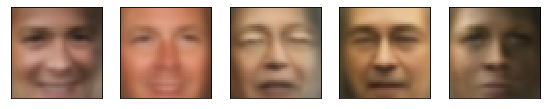

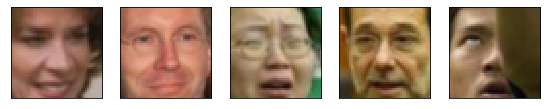

In [78]:
print(out_all.shape)
plot_gallery(to_print(out_all), 45, 45,3, 1,5)
plot_gallery(to_print(images_all), 45, 45,3, 1,5)



====> Test set loss 0.0003873469284906002


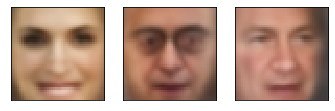

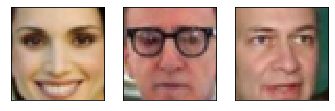

In [37]:
out_all_val, images_all_val, code_all_val = validate(data_val_conv,encoder, decoder,  optimizer, criterion)
plot_gallery(to_print(out_all_val), 45, 45,3, 1,3)
plot_gallery(to_print(images_all_val), 45, 45,3, 1,3)

In [34]:
# сохраняем модель для последующего использования
from google.colab import files
import helper

torch.save(decoder.state_dict(), 'decoder.pth')
torch.save(encoder.state_dict(), 'encoder.pth')

# download checkpoint file
files.download('decoder.pth')
files.download('encoder.pth')

#files.upload()
#files.upload()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

**If that doesn't work**
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [25]:
#Загружаем модель
enc_dict = torch.load('encoder.pth')
dec_dict = torch.load('decoder.pth')
encoder.load_state_dict(enc_dict)
decoder.load_state_dict(dec_dict)

<All keys matched successfully>

In [91]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(25, dim_code))
z_loader = DataLoader(z, batch_size=5)

In [93]:
out, outs = test_dec(z_loader, decoder)

torch.Size([5, 3, 45, 45])


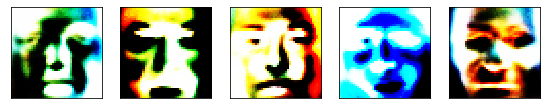

In [94]:
# призрак лица из белого шума
print(out.shape)
plot_gallery(to_print(out), 45, 45,3, 1,5)

В этот раз получились какие-то обезьянки. Однако когда я тестила это задание на обученной модели из большого и сложного автоэнкодера, то выводились достаточно странные, но все же лица нужного цвета. Но я не буду переобучать еще раз тот энкодер - куда постоянно падает из-за нехватки оперативки.

## РИСУЕМ УЛЫБКИ ХМУРЫМ ЛЮДЯМ

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [46]:
codes_grumpy = test_enc(data_loader=grumpy_tr)
codes_smile = test_enc(data_loader=smiling_tr)

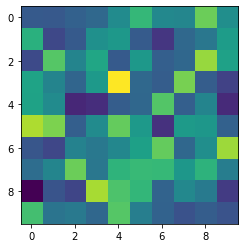

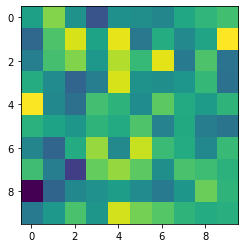

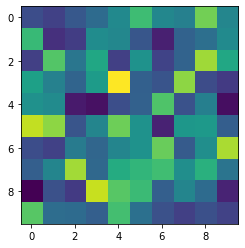

In [47]:
# функция решейпит код, чтобы он стал квадратным
def code_to_pic(code):
  return code.reshape(-1, 1, 10, 10)*255

smile = codes_smile - codes_grumpy
all = torch.stack((codes_smile, smile, codes_grumpy), dim=0)
all = code_to_pic(all)

for img in all.cpu().detach().numpy():

  plt.imshow(img.reshape((10, 10)))
  plt.show()


In [ ]:
images, _ = next(iter(grumpy_val))

images = images.to(device)
code = encoder(images)

# выход хмурых людей с добавлением вектора улыбки
out = decoder(code.add(smile[None,:].to(device)))

# выход хмурых людей бездобавления вектора улыбки
out2 = decoder(code)


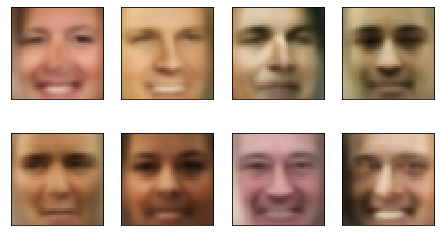

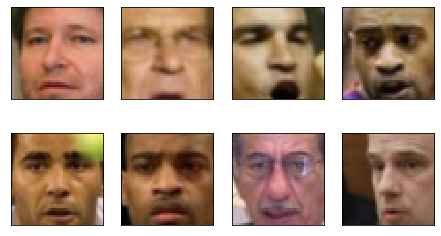

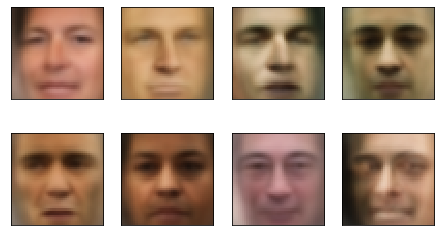

In [49]:
plot_gallery(to_print(out), 45,45,3,2,4)
plot_gallery(to_print(images), 45,45,3,2,4) # выводим оригинальное изображение для сравнения
plot_gallery(to_print(out2), 45,45,3,2,4)

УРА! Улыбки получились, после долгих и безуспешных попыток. 

ВЫВОД: как ни странно, под эту задачу лучше подходит модель с простой архитектурой, где в энкодере два сверточных слоя и два линейных, а в декодере просто два линейных. Сложная сеть с множественными свертками и апсэмплингом, во-первых, очень долго обучалась и обрушивала куду на гугл колабе, а во вторых совершенно не позволяла пририсовывать улыбки.

## ПОПРОБУЕМ ДОРИСОВАТЬ УСЫ

In [100]:
codes_no_goatee = test_enc(data_loader=no_goatee_tr)
codes_goatee = test_enc(data_loader=goatee_tr)

In [129]:
goatee = codes_goatee - codes_no_goatee

images, _ = next(iter(no_goatee_val))

images = images.to(device)
code = encoder(images)

# выход хмурых людей с добавлением вектора улыбки
out = decoder(code.add(goatee[None,:].to(device)))

# выход хмурых людей бездобавления вектора улыбки
out2 = decoder(code)


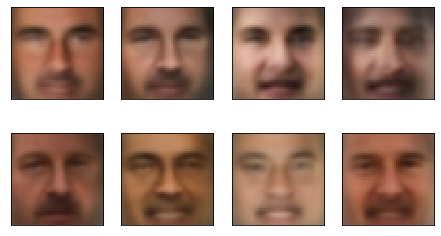

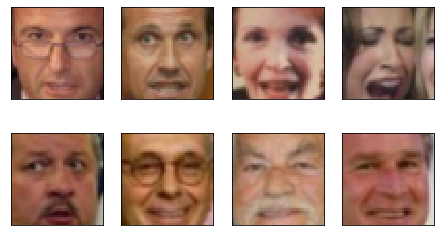

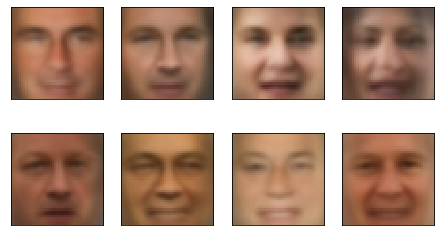

In [130]:
plot_gallery(to_print(out), 45,45,3,2,4)
plot_gallery(to_print(images), 45,45,3,2,4) # выводим оригинальное изображение для сравнения
plot_gallery(to_print(out2), 45,45,3,2,4)

# Загружаем MNIST датасет

In [7]:
trans = transforms.Compose([transforms.ToTensor()]) #, transforms.Normalize((0.5,), (1.0,))
root = './data'

# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

## VAE для MNIST

In [117]:
class VAE(nn.Module):
    def __init__(self, code_size, capacity):
        super().__init__()
        
        """
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        """
        
        self.code_size = code_size
        self.c = capacity
        
        # encoder
        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=N_CHANNELS, out_channels=self.c, kernel_size=4, stride=2, padding=1), # out: c x 14 x 14
          nn.ReLU(),
          nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1), # out: c x 7 x 7
          nn.ReLU()
        )
        
        # bottleneck
        self.mu = nn.Linear(in_features=self.c*2*7*7, out_features=code_size)
        self.logsigma = nn.Linear(in_features=self.c*2*7*7, out_features=code_size)
        self.fc_decoder = nn.Linear(in_features=code_size, out_features=self.c*2*7*7)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1),
        )


    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu


    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # flatten befor linear   
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        
        return mu, logsigma
    

    def decode(self, z):
        """
        <реализуйте forward проход декодера
         в качестве ваозвращаемой переменной -- reconstruction>
        """
        z = self.fc_decoder(z)
        z = z.view(z.size(0), capacity*2, 7, 7) # unflatten after linear
        reconstruction = torch.sigmoid(self.decoder(z))
        reconstruction = reconstruction.view(-1, N_CHANNELS, IMAGE_W, IMAGE_H)
        
        return reconstruction
        

    def forward(self, x):
        """
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        """
        mu, logsigma = self.encode(x)
        code = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(code)
        
        return mu, logsigma, reconstruction, code




Определим лосс и его компоненты для VAE:

## LOSS для VAE

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$



In [11]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -0.5 * torch.mean(1 + logsigma - mu.pow(2) - logsigma.exp())

def log_likelihood(reconstruction, x):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='mean')
    return  loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(reconstruction, x)


## Обучечние VAE

И обучим модель:

In [115]:
def train5(data_loader, model, epochs, optimizer, criterion):
  code = np.random.randn(1, dim_code)
  losses = []
  for epoch in range(epochs):
      
      for images, _ in data_loader: 
          
          optimizer.zero_grad()
          mu, logsigma, reconstruction, code = model(images.to(device))
          
          loss = criterion(images.to(device), mu, logsigma, reconstruction )
          loss.backward()
          optimizer.step()
      losses.append(loss.data.mean())
      print("Epoch = %i: Loss = %.3f" % (epoch, loss.data))
  return mu, logsigma, reconstruction, images, losses

def validate(data_loader,model, optimizer, criterion):
  model.eval()
  test_loss = 0
  codes = []
  for images, _ in data_loader:

      images = images.to(device)
      mu, logsigma, reconstruction, code = model(images)
      test_loss += criterion(images, mu, logsigma, reconstruction).item()
      codes.append(code.reshape(-1, dim_code, 1))

  test_loss /= len(data_loader.dataset)
  print('====> Test set loss', test_loss)
  return mu, logsigma, reconstruction, images, codes

In [118]:
criterion = loss_vae
dim_code = 10
capacity = 64
learning_rate = 1e-3
IMAGE_W, IMAGE_H = 28, 28
N_CHANNELS = 1
vae = VAE(dim_code, capacity).to(device)
optimizer = torch.optim.AdamW(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
epochs = 50
mu, logsigma, reconstruction, images, losses = train5(data_loader=train_loader, model=vae, epochs=epochs, optimizer=optimizer, criterion=criterion)


Epoch = 0: Loss = 0.136
Epoch = 1: Loss = 0.129
Epoch = 2: Loss = 0.115
Epoch = 3: Loss = 0.115
Epoch = 4: Loss = 0.116
Epoch = 5: Loss = 0.117
Epoch = 6: Loss = 0.107
Epoch = 7: Loss = 0.113
Epoch = 8: Loss = 0.109
Epoch = 9: Loss = 0.110
Epoch = 10: Loss = 0.112
Epoch = 11: Loss = 0.115
Epoch = 12: Loss = 0.099
Epoch = 13: Loss = 0.099
Epoch = 14: Loss = 0.108
Epoch = 15: Loss = 0.099
Epoch = 16: Loss = 0.102
Epoch = 17: Loss = 0.100
Epoch = 18: Loss = 0.103
Epoch = 19: Loss = 0.104
Epoch = 20: Loss = 0.103
Epoch = 21: Loss = 0.097
Epoch = 22: Loss = 0.099
Epoch = 23: Loss = 0.102
Epoch = 24: Loss = 0.103
Epoch = 25: Loss = 0.101
Epoch = 26: Loss = 0.108
Epoch = 27: Loss = 0.098
Epoch = 28: Loss = 0.107
Epoch = 29: Loss = 0.106
Epoch = 30: Loss = 0.099
Epoch = 31: Loss = 0.101
Epoch = 32: Loss = 0.097
Epoch = 33: Loss = 0.097
Epoch = 34: Loss = 0.097
Epoch = 35: Loss = 0.098
Epoch = 36: Loss = 0.102
Epoch = 37: Loss = 0.099
Epoch = 38: Loss = 0.107
Epoch = 39: Loss = 0.098
Epoch = 40

In [39]:
mu, logsigma, reconstruction, images, codes = validate(test_loader, vae,  optimizer, criterion)


====> Test set loss 0.036018470668792726


In [119]:
# сохраняем модель для последующего использования
from google.colab import files
import helper

torch.save(vae.state_dict(), 'vae4.pth')

# download checkpoint file
files.download('vae4.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Визуализация функции потерь при обучении

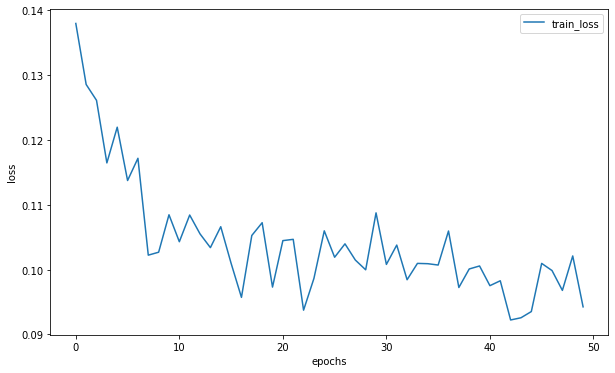

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Реконструкция картинок MNIST при помощи VAE

Original images


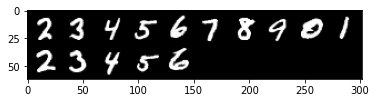

Reconstruction:


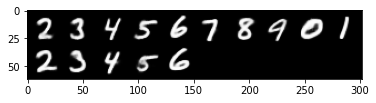

In [16]:
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        mu, logsigma, reconstruction, images = model(images)
        reconstruction = reconstruction.cpu()
        reconstruction = to_img(reconstruction)
        np_imagegrid = torchvision.utils.make_grid(reconstruction[1:20], 10, 2).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

#images, labels = iter(test_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images.cpu().detach()[1:20],10,2))
plt.show()

# Reconstruct and visualise the images using the vae
print('Reconstruction:')
visualise_output(images, vae)

And finally sample from VAE.

### Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

Reconstruction:


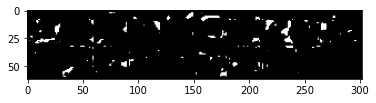

In [127]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(128, dim_code))
z_loader = DataLoader(z, batch_size=128)

vae.eval()   

def visualise_output(code, model):

    with torch.no_grad():
    
        
        #labels = transform_y(labels.view(-1, 1)).to(device)
        code = code.view(-1, dim_code).to(device)
        reconstruction = model.decode(code)
        reconstruction = reconstruction.cpu()
        reconstruction = to_img(reconstruction)
        np_imagegrid = torchvision.utils.make_grid(reconstruction[1:20].reshape(-1,1,28,28), 10, 2).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

code = iter(z_loader).next()


#print(labels)
# Reconstruct and visualise the images using the vae

print('Reconstruction:')
visualise_output(code, vae)


Мда... великий рандом не сработал!

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [40]:
code = torch.cat(codes).cpu().detach()
print(code.shape)

torch.Size([10000, 10, 1])


In [ ]:
#time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(code)

Что вы думаете о виде латентного представления?

# BONUS 1: Image Morphing (1 балл) 

Как видно, иногда что-то удается удачно восстановить, так что последний нолик получился вполне достойно ))

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

### VAE для датасета с лицами

In [12]:
class VAE(nn.Module):
    def __init__(self, code_size, capacity):
        super().__init__()
        
        """
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        """
        
        self.code_size = code_size
        self.c = capacity
        
        # encoder
        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=N_CHANNELS, out_channels=self.c, kernel_size=5, stride=2, padding=1), # out: c x 22 x 22
          nn.ReLU(),
          nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1), # out: c x 11 x 11
          nn.ReLU()
        )
        
        # bottleneck
        self.mu = nn.Linear(in_features=self.c*2*11*11, out_features=code_size)
        self.logsigma = nn.Linear(in_features=self.c*2*11*11, out_features=code_size)
        self.fc_decoder = nn.Linear(in_features=code_size, out_features=self.c*2*11*11)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=self.c, out_channels=N_CHANNELS, kernel_size=5, stride=2, padding=1)
            )


    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu


    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # flatten befor linear   
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        
        return mu, logsigma
    

    def decode(self, z):
        """
        <реализуйте forward проход декодера
         в качестве ваозвращаемой переменной -- reconstruction>
        """
        z = self.fc_decoder(z)
        z = z.view(z.size(0), capacity*2, 11, 11) # unflatten after linear
        reconstruction = torch.sigmoid(self.decoder(z))
        reconstruction = reconstruction.view(-1, N_CHANNELS, IMAGE_W, IMAGE_H)
        
        return reconstruction
        

    def forward(self, x):
        """
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        """
        mu, logsigma = self.encode(x)
        code = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(code)
        
        return mu, logsigma, reconstruction, code


### Обучение VAE на лицах

In [23]:
criterion = loss_vae
dim_code = 100
capacity = 124
learning_rate = 1e-3
IMAGE_W = IMAGE_H = 45
N_CHANNELS = 3
vae = VAE(dim_code, capacity).to(device)
optimizer = torch.optim.AdamW(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
epochs = 50
mu, logsigma, reconstruction, images, losses = train5(data_loader=data_tr_conv, model=vae, epochs=epochs, optimizer=optimizer, criterion=criterion)


Epoch = 0: Loss = 0.620
Epoch = 1: Loss = 0.613
Epoch = 2: Loss = 0.602
Epoch = 3: Loss = 0.608
Epoch = 4: Loss = 0.600
Epoch = 5: Loss = 0.591
Epoch = 6: Loss = 0.602
Epoch = 7: Loss = 0.598
Epoch = 8: Loss = 0.597
Epoch = 9: Loss = 0.593
Epoch = 10: Loss = 0.596
Epoch = 11: Loss = 0.585
Epoch = 12: Loss = 0.607
Epoch = 13: Loss = 0.608
Epoch = 14: Loss = 0.593
Epoch = 15: Loss = 0.609
Epoch = 16: Loss = 0.611
Epoch = 17: Loss = 0.586
Epoch = 18: Loss = 0.602
Epoch = 19: Loss = 0.588
Epoch = 20: Loss = 0.590
Epoch = 21: Loss = 0.606
Epoch = 22: Loss = 0.599
Epoch = 23: Loss = 0.590
Epoch = 24: Loss = 0.589
Epoch = 25: Loss = 0.613
Epoch = 26: Loss = 0.604
Epoch = 27: Loss = 0.602
Epoch = 28: Loss = 0.595
Epoch = 29: Loss = 0.606
Epoch = 30: Loss = 0.614
Epoch = 31: Loss = 0.607
Epoch = 32: Loss = 0.617
Epoch = 33: Loss = 0.592
Epoch = 34: Loss = 0.601
Epoch = 35: Loss = 0.610
Epoch = 36: Loss = 0.605
Epoch = 37: Loss = 0.602
Epoch = 38: Loss = 0.605
Epoch = 39: Loss = 0.605
Epoch = 40

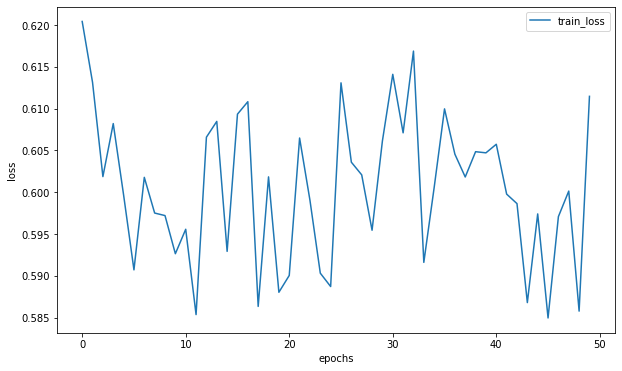

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Реконструкция лиц при помощи VAE

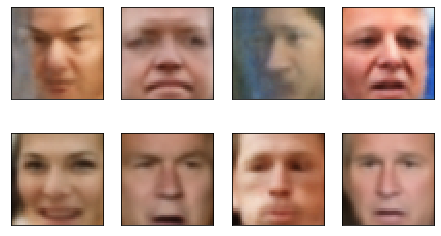

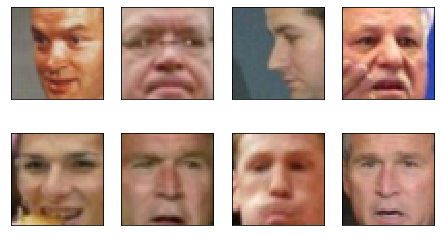

In [24]:
plot_gallery(to_print(reconstruction), 45,45,3,2,4)
plot_gallery(to_print(images), 45,45,3,2,4)

In [26]:
mu, logsigma, reconstruction, images, codes = validate(data_val_conv, vae,  optimizer, criterion)


====> Test set loss 0.08047479313344588


### Сохраняем обученную модель

In [27]:
# сохраняем модель для последующего использования
from google.colab import files
import helper

torch.save(vae.state_dict(), 'vae_faces.pth')

# download checkpoint file
files.download('vae_faces.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Визуализация функции потерь при обучении на лицах

Почему-то при обучении на лицаъ функция потерь практически не падает от первоначального значения, хотя обучение проходит успешно.

### Морфинг двух изображений

In [ ]:
image1 = torch.FloatTensor(X_smiling_val[208:209,:,:,:]).permute([0,3,1,2])
image2 = torch.FloatTensor(X_grumpy_val[195:196,:,:,:]).permute([0,3,1,2])

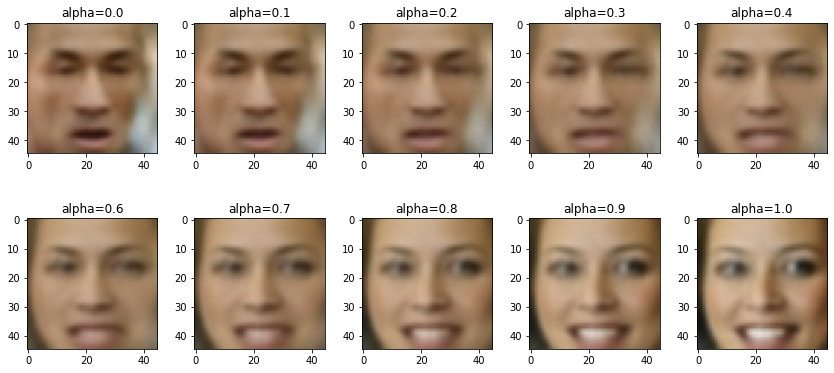

Original images:



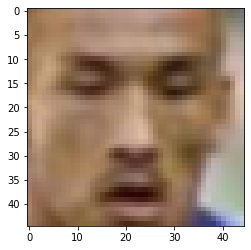

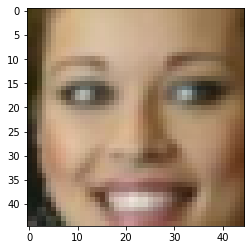

In [64]:
def morph(alpha, model, img1, img2):
    
    with torch.no_grad():
    
        # generate latent vectors for two images
        code1, _ = model.encode(img1.to(device))
        code2, _ = model.encode(img2.to(device))

        # merge two latent vectors according to formula αX+(1−α)Y
        code_merged = alpha * code1 + (1 - alpha) * code2
        image_morphed = model.decode(code_merged)

        return image_morphed.cpu()
    
# alpha 
alpha_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

image1, _ = next(iter(smiling_val))
image2, _ = next(iter(grumpy_val))

for i, alpha in enumerate(alpha_range):

  image_morphed = morph(float(alpha), vae, image1, image2)
  image_morphed = to_print(image_morphed).numpy()
  
  axs[i].imshow(image_morphed[1,:,:,:])
  axs[i].set_title('alpha='+str(round(alpha,1)))


plt.show()

print('Original images:\n')
plt.imshow(to_print(image2)[1,:,:,:])
plt.show() 
plt.imshow(to_print(image1)[1,:,:,:])
plt.show() 


Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

**P.S.**
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 


### Зашумляем данные для обучения

In [67]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 100

def add_noise(X, noise_factor=0.5):
  return X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

def prepare_loader(X, Y, batch_size, conv=False):
  if conv:
    X = torch.from_numpy(np.rollaxis(X.astype(np.float32)/255, 3,1))
  else:
    X = torch.from_numpy(X.astype(np.float32)/255) 
  
  Y = torch.Tensor(Y.values.astype(float))
  
  data_tr = TensorDataset(X, Y)
  data_tr = DataLoader(data_tr,  batch_size=batch_size, shuffle=True)

  return data_tr



### prepare data for smile substitution (I will use convolution based autoencoder, hence conv=True flag, as it moves chanels dimention before width and hight)
smiling_tr = prepare_loader(add_noise(X_train), Y_train, batch_size, conv=True)
smiling_val = prepare_loader(add_noise(X_val), Y_val, batch_size, conv=True)


### Загружаем ранее ообученную модель для сравнения

In [35]:
# загружаем ранее ообученную модель для сравнения.
from google.colab import files
import helper

files.upload()


Saving vae_faces.pth to vae_faces.pth


In [39]:
#Загружаем модель
dim_code = 100
vae = VAE(dim_code, capacity).to(device)
vae_dict = torch.load('vae_faces.pth')
vae.load_state_dict(vae_dict)

<All keys matched successfully>

### Обучаем модель на зашумленных данных

In [68]:
# Обучаем модель
epochs = 150
criterion = loss_vae
dim_code = 100
capacity = 124
learning_rate = 1e-3
IMAGE_W = IMAGE_H = 45
N_CHANNELS = 3
vae = VAE(dim_code, capacity).to(device)
optimizer = torch.optim.AdamW(vae.parameters(), lr=learning_rate, weight_decay=1e-5) #
#optimizer = torch.optim.SGD(vae.parameters(), lr=learning_rate) #, weight_decay=1e-5
mu, logsigma, reconstruction, images, losses = train5(data_loader=smiling_tr, model=vae, epochs=epochs, optimizer=optimizer, criterion=criterion)


Epoch = 0: Loss = 0.635
Epoch = 1: Loss = 0.619
Epoch = 2: Loss = 0.607
Epoch = 3: Loss = 0.616
Epoch = 4: Loss = 0.611
Epoch = 5: Loss = 0.608
Epoch = 6: Loss = 0.608
Epoch = 7: Loss = 0.612
Epoch = 8: Loss = 0.607
Epoch = 9: Loss = 0.608
Epoch = 10: Loss = 0.607
Epoch = 11: Loss = 0.604
Epoch = 12: Loss = 0.606
Epoch = 13: Loss = 0.597
Epoch = 14: Loss = 0.603
Epoch = 15: Loss = 0.601
Epoch = 16: Loss = 0.597
Epoch = 17: Loss = 0.598
Epoch = 18: Loss = 0.595
Epoch = 19: Loss = 0.604
Epoch = 20: Loss = 0.605
Epoch = 21: Loss = 0.600
Epoch = 22: Loss = 0.606
Epoch = 23: Loss = 0.601
Epoch = 24: Loss = 0.595
Epoch = 25: Loss = 0.598
Epoch = 26: Loss = 0.606
Epoch = 27: Loss = 0.598
Epoch = 28: Loss = 0.598
Epoch = 29: Loss = 0.595
Epoch = 30: Loss = 0.603
Epoch = 31: Loss = 0.595
Epoch = 32: Loss = 0.602
Epoch = 33: Loss = 0.605
Epoch = 34: Loss = 0.597
Epoch = 35: Loss = 0.604
Epoch = 36: Loss = 0.606
Epoch = 37: Loss = 0.591
Epoch = 38: Loss = 0.606
Epoch = 39: Loss = 0.597
Epoch = 40

### Реконструкция лиц после шума

In [ ]:
mu, logsigma, reconstruction, images, codes = validate(smiling_val,vae,  optimizer, criterion)
plot_gallery(to_print(reconstruction), 45, 45,3, 1,3)
plot_gallery(to_print(images), 45, 45,3, 1,3)

====> Test set loss 0.050742259906355745


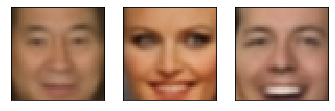

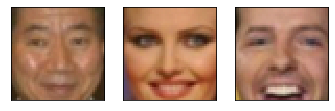

In [100]:
mu, logsigma, reconstruction, images, codes = validate(smiling_val,vae,  optimizer, criterion)
plot_gallery(to_print(reconstruction), 45, 45,3, 1,3)
plot_gallery(to_print(images), 45, 45,3, 1,3)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

### Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



In [71]:
class CVAE(nn.Module):
    def __init__(self, input_shape, code_size, N_CLASSES):
        super().__init__()
        # архитектура encoder
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape + N_CLASSES, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )
         
        # bottleneck
        self.mu = nn.Linear(128, code_size)
        self.logsigma = nn.Linear(128, code_size)
        self.fc_decoder = nn.Linear(code_size + N_CLASSES,138)
        
        # архитектура decoder
        self.decoder = nn.Sequential(
            nn.Linear(138, input_shape),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, input_shape)
        )

    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu


    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        
        return mu, logsigma
    

    def decode(self, z):
        """
        <реализуйте forward проход декодера
         в качестве ваозвращаемой переменной -- reconstruction>
        """
        z = self.fc_decoder(z)
        #print(z.shape)
        reconstruction = torch.sigmoid(self.decoder(z))
        #reconstruction = reconstruction.view(-1, N_CHANNELS, IMAGE_W, IMAGE_H)
        
        return reconstruction
        

    def forward(self, x, y):
        """
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        """
        x = torch.cat((x, y), dim=1)
        mu, logsigma = self.encode(x)
        code = self.gaussian_sampler(mu, logsigma)
        code = torch.cat((code, y), dim=1)
        reconstruction = self.decode(code)
        
        return mu, logsigma, reconstruction, code


### Обучение

In [61]:
# функция формирование вестора для определения класса
def transform_y(idx, n=N_CLASSES):

    res = torch.zeros(idx.size(0),n)
    res.scatter_(1, idx.data, 1)
    
    return res

def train6(data_loader, model, epochs, optimizer, criterion):
  code = np.random.randn(1, dim_code)
  losses = []
  for epoch in range(epochs):
      
      for images, labels in data_loader: 
          
          optimizer.zero_grad()

          images = images.view(-1,IMAGE_H * IMAGE_W * N_CHANNELS).to(device)
          labels = transform_y(labels.view(-1, 1)).to(device)

          mu, logsigma, reconstruction, code = model(images, labels)
          loss = criterion(images, mu, logsigma, reconstruction)
          
          loss.backward()
          optimizer.step()
      
      losses.append(loss.data.mean())
      print("Epoch = %i: Loss = %.3f" % (epoch, loss.data))
  
  return mu, logsigma, reconstruction, images, losses

def validate(data_loader,model, optimizer, criterion):
  model.eval()
  test_loss = 0
  codes = []
  for images, labels in data_loader:

      images = images.view(-1, IMAGE_H * IMAGE_W * N_CHANNELS).to(device)
      labels = transform_y(labels.view(-1, 1)).to(device)

      mu, logsigma, reconstruction, code = model(images, labels)
      test_loss += criterion(images, mu, logsigma, reconstruction).item()
      codes.append(code.reshape(-1, dim_code, 1))

  test_loss /= len(data_loader.dataset)
  print('====> Test set loss', test_loss)
  return mu, logsigma, reconstruction, images, codes

In [72]:
criterion = loss_vae
dim_code = 10
learning_rate = 1e-3
IMAGE_W = IMAGE_H = 28
N_CHANNELS = 1
N_CLASSES = 10
input_shape = IMAGE_W * IMAGE_H * N_CHANNELS 

cvae = CVAE(code_size=dim_code, input_shape=input_shape, N_CLASSES=N_CLASSES).to(device)
optimizer = torch.optim.AdamW(cvae.parameters(), lr=learning_rate, weight_decay=1e-5)
epochs = 50
mu, logsigma, reconstruction, images, losses = train6(data_loader=train_loader, model=cvae, epochs=epochs, optimizer=optimizer, criterion=criterion)

Epoch = 0: Loss = 0.277
Epoch = 1: Loss = 0.185
Epoch = 2: Loss = 0.159
Epoch = 3: Loss = 0.138
Epoch = 4: Loss = 0.132
Epoch = 5: Loss = 0.129
Epoch = 6: Loss = 0.128
Epoch = 7: Loss = 0.124
Epoch = 8: Loss = 0.125
Epoch = 9: Loss = 0.118
Epoch = 10: Loss = 0.113
Epoch = 11: Loss = 0.116
Epoch = 12: Loss = 0.112
Epoch = 13: Loss = 0.117
Epoch = 14: Loss = 0.111
Epoch = 15: Loss = 0.111
Epoch = 16: Loss = 0.116
Epoch = 17: Loss = 0.109
Epoch = 18: Loss = 0.108
Epoch = 19: Loss = 0.116
Epoch = 20: Loss = 0.110
Epoch = 21: Loss = 0.113
Epoch = 22: Loss = 0.112
Epoch = 23: Loss = 0.117
Epoch = 24: Loss = 0.103
Epoch = 25: Loss = 0.110
Epoch = 26: Loss = 0.110
Epoch = 27: Loss = 0.108
Epoch = 28: Loss = 0.107
Epoch = 29: Loss = 0.102
Epoch = 30: Loss = 0.107
Epoch = 31: Loss = 0.107
Epoch = 32: Loss = 0.103
Epoch = 33: Loss = 0.106
Epoch = 34: Loss = 0.101
Epoch = 35: Loss = 0.099
Epoch = 36: Loss = 0.103
Epoch = 37: Loss = 0.104
Epoch = 38: Loss = 0.103
Epoch = 39: Loss = 0.106
Epoch = 40

In [79]:
mu, logsigma, reconstruction, images, codes = validate(test_loader,cvae, optimizer, criterion)

====> Test set loss 0.035054261922836304


### Визауализация

Original images


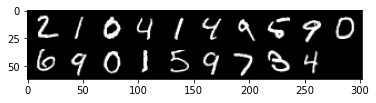

Reconstruction:


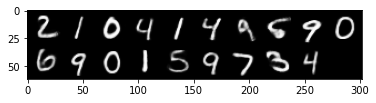

In [74]:
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

cvae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, labels, model):

    with torch.no_grad():
    
        images = images.view(-1,IMAGE_H * IMAGE_W * N_CHANNELS).to(device)
        labels = transform_y(labels.view(-1, 1)).to(device)
        mu, logsigma, reconstruction, images = model(images, labels)
        reconstruction = reconstruction.cpu()
        reconstruction = to_img(reconstruction)
        np_imagegrid = torchvision.utils.make_grid(reconstruction[1:20].reshape(-1,1,28,28), 10, 2).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images.cpu().detach()[1:20],10,2))
plt.show()

# Reconstruct and visualise the images using the vae
print('Reconstruction:')
visualise_output(images, labels, cvae)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [112]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(128, dim_code))
z_loader = DataLoader(z, batch_size=128)

Reconstruction:


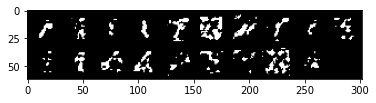

In [113]:
def transform_y(idx, n=N_CLASSES):

    res = torch.zeros(idx.size(0),n)#n)
    res.scatter_(1, idx.data, 1)
    
    return res
cvae.eval()   
def visualise_output(code, labels, model):

    with torch.no_grad():
    
        
        labels = transform_y(labels.view(-1, 1)).to(device)
        code = code.view(-1, dim_code).to(device)
        #print(code.shape, labels.shape)
        code = torch.cat((code, labels), dim=1)
        #print(code.shape)
        reconstruction = model.decode(code)
        reconstruction = reconstruction.cpu()
        reconstruction = to_img(reconstruction)
        np_imagegrid = torchvision.utils.make_grid(reconstruction[1:20].reshape(-1,1,28,28), 10, 2).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

code = iter(z_loader).next()
_, labels = iter(test_loader).next()

#print(labels)
# Reconstruct and visualise the images using the vae

print('Reconstruction:')
visualise_output(code, labels, cvae)

**Sampling у меня упорно выходит крайне упоротый, простите за тавтологию. Мне кажется, что тут дело либо в рандоме, либо в архитектуре. Но учится же сетка нормально, и на валидационной выборке дает вполне приличные результаты! В общем, надо тестировать и разбираться, а времени на это уже нет, так что засим позвольте раскланяться! Было и правда очень увлекательно! Спасибо!**

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!